In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Velocidades circulares - GADGET

In [7]:
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import sphviewer as sph
import numpy as np

vector = ('00','01','03')
vector2 = ('M31', 'MW', 'M33')
h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

# path = '/home/ornela/SimCLUES/'
path = '/home/omarioni/'
atime = np.loadtxt(path + 'redshift_outputs.txt')
aexp = atime[:,2]
aexp = aexp[::-1]

path = '/mnt/is2/alejandro/ornella/'

snapshot=range(496,495,-1)

for isnap in snapshot:
    snap = h5py.File(path + 'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    
    for i in range(0,3):
        cm   = snap['subhalo_0'+ str('%s'%vector[i])+ '/Center'].value
        r200 = snap['subhalo_0'+ str('%s'%vector[i])+ '/R200'].value
        
        pstr = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
        mstr = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Masses'].value
        vel  = snap['subhalo_0'+ str('%s'%vector[i])+ '/Str/Velocities'].value
        
        pgas = snap['subhalo_0'+ str('%s'%vector[i])+ '/Gas/Coordinates'].value
        mgas = snap['subhalo_0'+ str('%s'%vector[i])+ '/Gas/Masses'].value
        
        pdrk = snap['subhalo_0'+ str('%s'%vector[i]) + '/Drk/Coordinates'].value
        mdrk = snap['subhalo_0'+ str('%s'%vector[i])+ '/Drk/Masses'].value
        
        z = a0/aexp[0] - 1.
        Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
        
#---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0])*aexp[0]/h
        ystr = (pstr[:,1]-cm[1])*aexp[0]/h
        zstr = (pstr[:,2]-cm[2])*aexp[0]/h
        rstr = np.sqrt(xstr**2+ystr**2+zstr**2)
        
        xgas = (pgas[:,0]-cm[0])*aexp[0]/h
        ygas = (pgas[:,1]-cm[1])*aexp[0]/h
        zgas = (pgas[:,2]-cm[2])*aexp[0]/h
        rgas = np.sqrt(xgas**2+ygas**2+zgas**2)
        
        xdrk = (pdrk[:,0]-cm[0])*aexp[0]/h
        ydrk = (pdrk[:,1]-cm[1])*aexp[0]/h
        zdrk = (pdrk[:,2]-cm[2])*aexp[0]/h
        rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
         
        v_x = vel[:,0] *np.sqrt(aexp[0]) + Ht *xstr/1000.
        v_y = vel[:,1] *np.sqrt(aexp[0]) + Ht *ystr/1000.
        v_z = vel[:,2] *np.sqrt(aexp[0]) + Ht *zstr/1000.
#----------------------masas----------------------------
        mstr = mstr/h
        mgas = mgas/h
        mdrk = mdrk/h
        
        r200 = r200*aexp[0]/h
        
        print 'r200 =', r200
        rgal=0.15*r200
        
        limit    = np.where(rstr<rgal)
        r_sort   = np.sort(rstr[limit])
        r_indice = np.argsort(rstr[limit])
        
        limit_str   = np.where(rstr<r200)
        rstr_sort   = np.sort(rstr[limit_str])
        rstr_indice = np.argsort(rstr[limit_str])
        
        limit_gas   = np.where(rgas<r200)
        rgas_sort   = np.sort(rgas[limit_gas])
        rgas_indice = np.argsort(rgas[limit_gas])
        
        limit_drk   = np.where(rdrk<r200)
        rdrk_sort   = np.sort(rdrk[limit_drk])
        rdrk_indice = np.argsort(rdrk[limit_drk])
        
        
        Mgal_str = cumsum((mstr[limit])[r_indice])
        
        Mc_str = cumsum((mstr[limit_str])[rstr_indice])
        
        Mc_gas = cumsum((mgas[limit_gas])[rgas_indice])
        
        Mc_drk = cumsum((mdrk[limit_drk])[rdrk_indice])
        
#------------------ calculamos r90, r50------------------------------------------
        M_gal = Mgal_str[-1]
    
        razon       = Mgal_str/M_gal
        setentaycinco,= np.where(razon < 0.75)
        cincuenta,    = np.where(razon < 0.50)
        veinticinco,  = np.where(razon < 0.25)
        
        r75 = r_sort[setentaycinco][-1]
        r50 = r_sort[cincuenta][-1]
        r25 = r_sort[veinticinco][-1]
#--------------------------------------------------------------       
        rtot = concatenate([rstr, rgas, rdrk])
        mtot = concatenate([mstr, mgas, mdrk])
        
        limit_tot   = np.where(rtot<r200)
        rtot_sort   = np.sort(rtot[limit_tot])
        rtot_indice = np.argsort(rtot[limit_tot])
        
        Mc_tot = cumsum((mtot[limit_tot])[rtot_indice])
        
        #print 'Mvir=', Mc_tot[-1], 'r50=', r50[-1]
#--------------------------------------------------------------
        
        Vtot = np.sqrt((G*Mc_tot*1e10)/rtot_sort)
        Vstr = np.sqrt((G*Mc_str*1e10)/rstr_sort)
        Vgas = np.sqrt((G*Mc_gas*1e10)/rgas_sort)
        Vdrk = np.sqrt((G*Mc_drk*1e10)/rdrk_sort)
        
#----------------------------------------------------------------------------------

        data = np.zeros([np.size(rtot_sort),8])
        data[:np.size(rstr_sort),0]= rstr_sort 
        data[:np.size(rgas_sort),1]= rgas_sort
        data[:np.size(rdrk_sort),2]= rdrk_sort
        data[:np.size(rtot_sort),3]= rtot_sort
        data[:np.size(rstr_sort),4]= Vstr 
        data[:np.size(rgas_sort),5]= Vgas
        data[:np.size(rdrk_sort),6]= Vdrk
        data[:np.size(rtot_sort),7]= Vtot
        
        data2 = np.ndarray([4,1])
        data2[0] = r200
        data2[1] = r50
        data2[2] = r25
        data2[3] = r75
        
        data3 = np.zeros([np.size(rtot_sort),10])
        data3[:np.size(rstr_sort),0]= rstr_sort 
        data3[:np.size(rdrk_sort),2]= rdrk_sort
        data3[:np.size(rtot_sort),3]= rtot_sort
        data3[:np.size(r_sort),4]   = r_sort 
        data3[:np.size(rstr_sort),5]= Mc_str 
        data3[:np.size(rgas_sort),6]= Mc_gas
        data3[:np.size(rdrk_sort),7]= Mc_drk
        data3[:np.size(rtot_sort),8]= Mc_tot
        data3[:np.size(r_sort),9]   = Mgal_str

        np.savetxt('/home/omarioni/Barras_GdGs/Barras_Gd/_data/'+str('%s'%vector2[i])+'_Mcum.dat', data3)
#         np.savetxt('/home/omarioni/Barras_GdGs/Barras_Gd/_data/'+str('%s'%vector2[i])+'_radios.dat', data2)

r200 = 167.210382514
r200 = 153.542349727
r200 = 123.112021858


### Velocidades circulares - GASOLINE

In [8]:
#Graficamos la veloc circular pero con la flecha de V200 y solo para los 3 halos mas grandes
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import sphviewer as sph
import numpy as np

vector = (1,2,4)
vector2 = ('M31', 'MW', 'M33')
G = 4.299e-6
a0 =1.

path = '/mnt/sersic2/omarioni/'

snapshot = np.loadtxt(path+'Gasoline/snapshots.txt', dtype='string')


snap = h5py.File(path+'Gasoline/outputs2/snap_1024.h5py', 'r')

for i in range(0,3):
    cm   = snap['subhalo_00'+ str('%s' %vector[i])+ '/Center'].value
    r200 = snap['subhalo_00'+ str('%s' %vector[i])+ '/R200'].value
    aexp = snap['subhalo_00'+ str('%s' %vector[i])+ '/aexp'].value
    h    = snap['subhalo_00'+ str('%s' %vector[i])+ '/h'].value
    
    omega_lambda = snap['subhalo_00'+ str('%s' %vector[i])+ '/OmegaL0'].value
    omega_matter = snap['subhalo_00'+ str('%s' %vector[i])+ '/OmegaM0'].value

    pstr = snap['subhalo_00'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
    mstr = snap['subhalo_00'+ str('%s' %vector[i]) + '/Str/Masses'].value
    vel  = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Velocities'].value

    pgas = snap['subhalo_00'+ str('%s' %vector[i])+ '/Gas/Coordinates'].value
    mgas = snap['subhalo_00'+ str('%s' %vector[i])+ '/Gas/Masses'].value

    pdrk = snap['subhalo_00'+ str('%s' %vector[i]) + '/Drk/Coordinates'].value
    mdrk = snap['subhalo_00'+ str('%s' %vector[i])+ '/Drk/Masses'].value

    H0 = h*100
    z = a0/aexp - 1.
    omega0 = omega_lambda + omega_matter
    Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)

#---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = (pstr[:,0]-cm[0]) #*aexp
    ystr = (pstr[:,1]-cm[1])
    zstr = (pstr[:,2]-cm[2])
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    xgas = (pgas[:,0]-cm[0])
    ygas = (pgas[:,1]-cm[1])
    zgas = (pgas[:,2]-cm[2])
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

    xdrk = (pdrk[:,0]-cm[0])
    ydrk = (pdrk[:,1]-cm[1])
    zdrk = (pdrk[:,2]-cm[2])
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

    #v_x = vel[:,0] *np.sqrt(aexp) + Ht *xstr/1000.
    #v_y = vel[:,1] *np.sqrt(aexp) + Ht *ystr/1000.
    #v_z = vel[:,2] *np.sqrt(aexp) + Ht *zstr/1000.
    
    v_x = vel[:,0] 
    v_y = vel[:,1] 
    v_z = vel[:,2]

#------------------------------------------------
    r200 = r200*aexp
    
    print 'r200=', r200
    rgal=0.15*r200

    limit    = np.where(rstr<rgal)
    r_sort   = np.sort(rstr[limit])
    r_indice = np.argsort(rstr[limit])

    limit_str   = np.where(rstr<r200)
    rstr_sort   = np.sort(rstr[limit_str])
    rstr_indice = np.argsort(rstr[limit_str])

    limit_gas   = np.where(rgas<r200)
    rgas_sort   = np.sort(rgas[limit_gas])
    rgas_indice = np.argsort(rgas[limit_gas])

    limit_drk   = np.where(rdrk<r200)
    rdrk_sort   = np.sort(rdrk[limit_drk])
    rdrk_indice = np.argsort(rdrk[limit_drk])


    Mgal_str = cumsum((mstr[limit])[r_indice])

    Mc_str = cumsum((mstr[limit_str])[rstr_indice])

    Mc_gas = cumsum((mgas[limit_gas])[rgas_indice])

    Mc_drk = cumsum((mdrk[limit_drk])[rdrk_indice])

#------------------ calculamos r90, r50------------------------------------------
    M_gal = Mgal_str[-1]

    razon       = Mgal_str/M_gal
    setentaycinco,= np.where(razon < 0.75)
    cincuenta,    = np.where(razon < 0.50)
    veinticinco,  = np.where(razon < 0.25)

    r75 = r_sort[setentaycinco][-1]
    r50 = r_sort[cincuenta][-1]
    r25 = r_sort[veinticinco][-1]
#--------------------------------------------------------------       
    rtot= concatenate([rstr, rgas, rdrk])
    mtot= concatenate([mstr, mgas, mdrk])

    limit_tot = np.where(rtot<r200)
    rtot_sort = np.sort(rtot[limit_tot])
    rtot_indice = np.argsort(rtot[limit_tot])
    
    Mc_tot = cumsum((mtot[limit_tot])[rtot_indice])


#calculo rvir------------------------------------------
    '''rho_crit=3*(H0/1000)**2/(8*pi*G)
    rho=Mc_tot1*3/(4*pi*rtot_sort1**3)
    delta=rho/rho_crit
    kk=np.where(delta<200)
    rvir=rtot_sort1[kk]
    print rvir[0],(delta[kk])[0]'''
#--------------------------------------------------------------
    Mc_tot = Mc_tot[1:]
    Mc_str = Mc_str[1:]
    Mc_gas = Mc_gas[1:]
    Mc_drk = Mc_drk[1:]

    rtot_sort = rtot_sort[1:]
    rstr_sort = rstr_sort[1:]
    rgas_sort = rgas_sort[1:]
    rdrk_sort = rdrk_sort[1:]

    Vtot = np.sqrt((G*Mc_tot)/rtot_sort)
    Vstr = np.sqrt((G*Mc_str)/rstr_sort)
    Vgas = np.sqrt((G*Mc_gas)/rgas_sort)
    Vdrk = np.sqrt((G*Mc_drk)/rdrk_sort)

#     Vvir = Vtot[-1]
    
    data = np.zeros([np.size(rtot_sort),8])
    data[:np.size(rstr_sort),0]= rstr_sort 
    data[:np.size(rgas_sort),1]= rgas_sort
    data[:np.size(rdrk_sort),2]= rdrk_sort
    data[:np.size(rtot_sort),3]= rtot_sort
    data[:np.size(rstr_sort),4]= Vstr 
    data[:np.size(rgas_sort),5]= Vgas
    data[:np.size(rdrk_sort),6]= Vdrk
    data[:np.size(rtot_sort),7]= Vtot

#     np.savetxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gs/_data/'+str('%s'%vector2[i])+'_Vcirc.dat', data, fmt='%12.6f')

    data2 = np.ndarray([4,1])
    data2[0] = r200
    data2[1] = r50
    data2[2] = r25
    data2[3] = r75
    
    
    data3 = np.zeros([np.size(rtot_sort),10])
    data3[:np.size(rstr_sort),0]= rstr_sort 
    data3[:np.size(rgas_sort),1]= rgas_sort
    data3[:np.size(rdrk_sort),2]= rdrk_sort
    data3[:np.size(rtot_sort),3]= rtot_sort
    data3[:np.size(r_sort),4]   = r_sort
    data3[:np.size(rstr_sort),5]= Mc_str 
    data3[:np.size(rgas_sort),6]= Mc_gas
    data3[:np.size(rdrk_sort),7]= Mc_drk
    data3[:np.size(rtot_sort),8]= Mc_tot
    data3[:np.size(r_sort),9]   = Mgal_str

    np.savetxt('/home/omarioni/Barras_GdGs/Barras_Gs/_data/'+str('%s'%vector2[i])+'_Mcum.dat', data3)
#     np.savetxt('/home/omarioni/Barras_GdGs/Barras_Gs/_data/'+str('%s'%vector2[i])+'_radios.dat', data2)

r200= 166.840000002
r200= 150.460000002
r200= 119.620000002


In [22]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

#path = 'home/ornela/PYTHON/'
path = '/home/omarioni/'

M31_gd  = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_Vcirc.dat')
rstr_M31gd = M31_gd[:,0]
rgas_M31gd = M31_gd[:,1]
rdrk_M31gd = M31_gd[:,2]
rtot_M31gd = M31_gd[:,3]
Vstr_M31gd = M31_gd[:,4]
Vgas_M31gd = M31_gd[:,5]
Vdrk_M31gd = M31_gd[:,6]
Vtot_M31gd = M31_gd[:,7]

MW_gd  = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/MW_Vcirc.dat')
rstr_MWgd = MW_gd[:,0]
rgas_MWgd = MW_gd[:,1]
rdrk_MWgd = MW_gd[:,2]
rtot_MWgd = MW_gd[:,3]
Vstr_MWgd = MW_gd[:,4]
Vgas_MWgd = MW_gd[:,5]
Vdrk_MWgd = MW_gd[:,6]
Vtot_MWgd = MW_gd[:,7]

M33_gd  = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M33_Vcirc.dat')
rstr_M33gd = M33_gd[:,0]
rgas_M33gd = M33_gd[:,1]
rdrk_M33gd = M33_gd[:,2]
rtot_M33gd = M33_gd[:,3]
Vstr_M33gd = M33_gd[:,4]
Vgas_M33gd = M33_gd[:,5]
Vdrk_M33gd = M33_gd[:,6]
Vtot_M33gd = M33_gd[:,7]

M31_gs  = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M31_Vcirc.dat')
rstr_M31gs = M31_gs[:,0]
rgas_M31gs = M31_gs[:,1]
rdrk_M31gs = M31_gs[:,2]
rtot_M31gs = M31_gs[:,3]
Vstr_M31gs = M31_gs[:,4]
Vgas_M31gs = M31_gs[:,5]
Vdrk_M31gs = M31_gs[:,6]
Vtot_M31gs = M31_gs[:,7]

MW_gs  = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/MW_Vcirc.dat')
rstr_MWgs = MW_gs[:,0]
rgas_MWgs = MW_gs[:,1]
rdrk_MWgs = MW_gs[:,2]
rtot_MWgs = MW_gs[:,3]
Vstr_MWgs = MW_gs[:,4]
Vgas_MWgs = MW_gs[:,5]
Vdrk_MWgs = MW_gs[:,6]
Vtot_MWgs = MW_gs[:,7]

M33_gs  = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M33_Vcirc.dat')
rstr_M33gs = M33_gs[:,0]
rgas_M33gs = M33_gs[:,1]
rdrk_M33gs = M33_gs[:,2]
rtot_M33gs = M33_gs[:,3]
Vstr_M33gs = M33_gs[:,4]
Vgas_M33gs = M33_gs[:,5]
Vdrk_M33gs = M33_gs[:,6]
Vtot_M33gs = M33_gs[:,7]


In [12]:
path = '/home/omarioni/'

radios_M31gd  = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_radios.dat')
r200_M31gd = radios_M31gd[0]
r50_M31gd  = radios_M31gd[1]
r25_M31gd  = radios_M31gd[2]
r75_M31gd  = radios_M31gd[3]

radios_MWgd  = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/MW_radios.dat')
r200_MWgd = radios_MWgd[0]
r50_MWgd  = radios_MWgd[1]
r25_MWgd  = radios_MWgd[2]
r75_MWgd  = radios_MWgd[3]

radios_M33gd  = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M33_radios.dat')
r200_M33gd = radios_M33gd[0]
r50_M33gd  = radios_M33gd[1]
r25_M33gd  = radios_M33gd[2]
r75_M33gd  = radios_M33gd[3]

radios_M31gs  = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M31_radios.dat')
r200_M31gs = radios_M31gs[0]
r50_M31gs  = radios_M31gs[1]
r25_M31gs  = radios_M31gs[2]
r75_M31gs  = radios_M31gs[3]

radios_MWgs  = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/MW_radios.dat')
r200_MWgs = radios_MWgs[0]
r50_MWgs  = radios_MWgs[1]
r25_MWgs  = radios_MWgs[2]
r75_MWgs  = radios_MWgs[3]

radios_M33gs  = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M33_radios.dat')
r200_M33gs = radios_M33gs[0]
r50_M33gs  = radios_M33gs[1]
r25_M33gs  = radios_M33gs[2]
r75_M33gs  = radios_M33gs[3]

In [11]:
#path = 'home/ornela/PYTHON/'
path = '/home/omarioni/'

M31_gd  = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_Mcum.dat')
rstr_M31gd = M31_gd[:,0]
rgas_M31gd = M31_gd[:,1]
rdrk_M31gd = M31_gd[:,2]
rtot_M31gd = M31_gd[:,3]
# rsortM31gd = M31_gd[:,4]
Mcstr_M31gd = M31_gd[:,5]
Mcgas_M31gd = M31_gd[:,6]
Mcdrk_M31gd = M31_gd[:,7]
Mctot_M31gd = M31_gd[:,8]
Mgal_M31gd  = M31_gd[:,9][-1]

MW_gd  = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/MW_Mcum.dat')
rstr_MWgd = MW_gd[:,0]
rgas_MWgd = MW_gd[:,1]
rdrk_MWgd = MW_gd[:,2]
rtot_MWgd = MW_gd[:,3]
# rsortMWgd = MW_gd[:,4]
Mcstr_MWgd = MW_gd[:,5]
Mcgas_MWgd = MW_gd[:,6]
Mcdrk_MWgd = MW_gd[:,7]
Mctot_MWgd = MW_gd[:,8]
Mgal_MWgd  = MW_gd[:,9][-1]

M33_gd  = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M33_Mcum.dat')
rstr_M33gd = M33_gd[:,0]
rgas_M33gd = M33_gd[:,1]
rdrk_M33gd = M33_gd[:,2]
rtot_M33gd = M33_gd[:,3]
# rsortM33gd = M33_gd[:,4]
Mcstr_M33gd = M33_gd[:,5]
Mcgas_M33gd = M33_gd[:,6]
Mcdrk_M33gd = M33_gd[:,7]
Mctot_M33gd = M33_gd[:,8]
Mgal_M33gd  = M33_gd[:,9][-1]

#----------------------------------------------------------------------------------

M31_gs  = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M31_Mcum.dat')
rstr_M31gs = M31_gs[:,0]
rgas_M31gs = M31_gs[:,1]
rdrk_M31gs = M31_gs[:,2]
rtot_M31gs = M31_gs[:,3]
# rsortM31gs = M31_gs[:,4]
Mcstr_M31gs = M31_gs[:,5]
Mcgas_M31gs = M31_gs[:,6]
Mcdrk_M31gs = M31_gs[:,7]
Mctot_M31gs = M31_gs[:,8]
Mgal_M31gs  = M31_gs[:,9][-1]

MW_gs  = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/MW_Mcum.dat')
rstr_MWgs = MW_gs[:,0]
rgas_MWgs = MW_gs[:,1]
rdrk_MWgs = MW_gs[:,2]
rtot_MWgs = MW_gs[:,3]
# rsortMWgs = MW_gs[:,4]
Mcstr_MWgs = MW_gs[:,5]
Mcgas_MWgs = MW_gs[:,6]
Mcdrk_MWgs = MW_gs[:,7]
Mctot_MWgs = MW_gs[:,8]
Mgal_MWgs  = MW_gs[:,9][-1]

M33_gs  = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M33_Mcum.dat')
rstr_M33gs = M33_gs[:,0]
rgas_M33gs = M33_gs[:,1]
rdrk_M33gs = M33_gs[:,2]
rtot_M33gs = M33_gs[:,3]
# rsortM33gs = M33_gs[:,4]
Mcstr_M33gs = M33_gs[:,5]
Mcgas_M33gs = M33_gs[:,6]
Mcdrk_M33gs = M33_gs[:,7]
Mctot_M33gs = M33_gs[:,8]
Mgal_M33gs  = M33_gs[:,9][-1]


In [50]:
print r200_M31gd*0.15

25.081557377


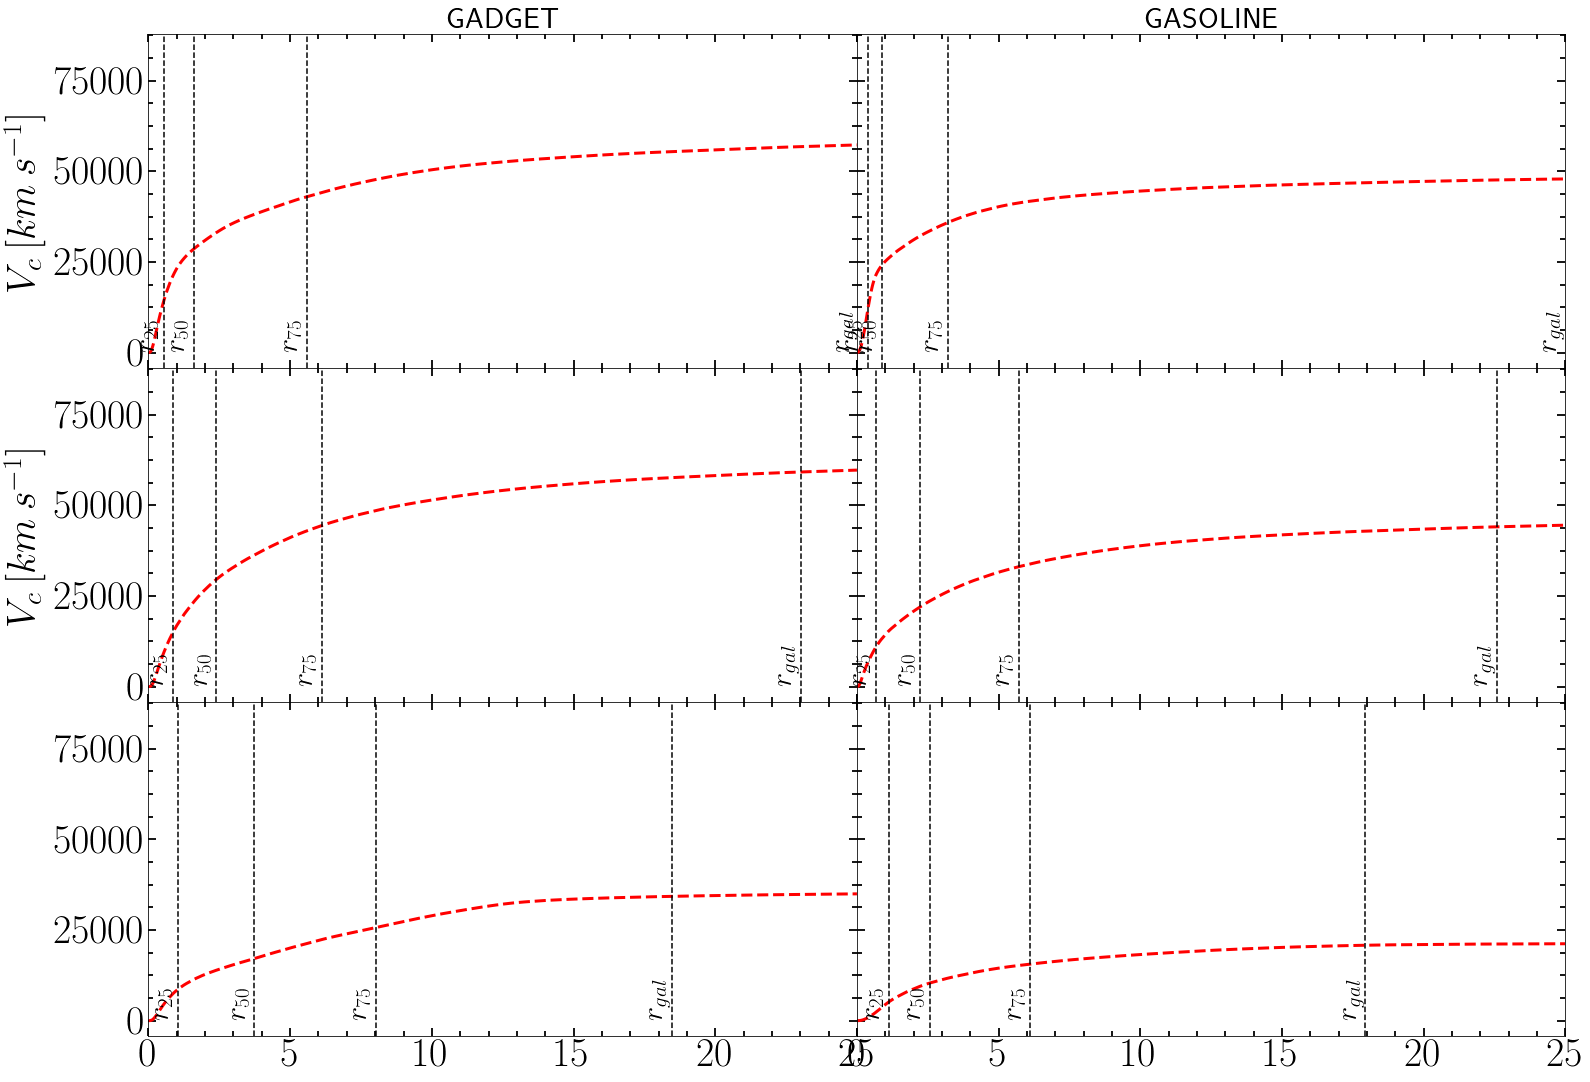

In [29]:
# fig=plt.figure(1,figsize=(16,16))
# fig.subplots_adjust(bottom=0.08, left =0.1, right = 0.95, top = 0.95, wspace=0., hspace= 0)

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(24, 16), sharey=True, sharex=True)
#                        gridspec_kw = {'height_ratios':[3,1,3,1]})
fig.subplots_adjust(bottom=0.08, left =0.1, right = 0.92, top = 0.95, wspace=0., hspace= 0)

# ax=fig.add_subplot(221)
# ax[0,0].plot(rtot_M31gd[np.where(Vtot_M31gd!=0)],Vtot_M31gd[np.where(Vtot_M31gd!=0)],'-', lw=3, color='k', label= 'Total')
ax[0,0].plot(rstr_M31gd[np.where(Vstr_M31gd!=0)],rstr_M31gd[np.where(Vstr_M31gd!=0)]*Vstr_M31gd[np.where(Vstr_M31gd!=0)]**2,'--',lw=3, color='r', label ='Stars')
# ax[0,0].plot(rgas_M31gd[np.where(Vgas_M31gd!=0)],Vgas_M31gd[np.where(Vgas_M31gd!=0)],':', color ='b',lw=3, label='Gas')
# ax[0,0].plot(rdrk_M31gd[np.where(Vdrk_M31gd!=0)],Vdrk_M31gd[np.where(Vdrk_M31gd!=0)],'-.',color='g', lw=3, label='Dark Matter')

# ax[0,0].text(18, 175, 'A', fontsize=35, color='k', ha='right', va='center')
#plt.legend(handles=[total,stars,gas,drk],fontsize=18, frameon=False)
# ax[0,0].set_xticks([0,5,10,15])
ax[0,0].set_ylabel(r'$V_{c}\:[km\:s^{-1}]$', fontsize=40)
# ax[0,0].set_xscale('log')
# ax[0,0].set_yscale('log')
# ax[0,0].set_ylim(2,2e2)
# ax[0,0].set_xlim(3e-2,2e2)
# ax[0,0].set_xticks([1e-2,1e-1,1e0,1e1,1e2], minor=True)
# ax[0,0].set_xticklabels([])

ax[0,0].minorticks_on()
ax[0,0].tick_params( labelsize=40)
ax[0,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')

# ax[0,0].axvline(r200_M31gd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
# ax[0,0].text(r200_M31gd, 3.5, '$r_{200}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[0,0].axvline(r200_M31gd*0.15,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[0,0].text(r200_M31gd*0.15, 3.5, '$r_{gal}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[0,0].axvline(r50_M31gd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[0,0].text(r50_M31gd, 3.5, '$r_{50}$', fontsize=30, color='black', ha='right', va='bottom', rotation=90.)

ax[0,0].axvline(r25_M31gd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[0,0].text(r25_M31gd, 3.5, '$r_{25}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[0,0].axvline(r75_M31gd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[0,0].text(r75_M31gd, 3.5, '$r_{75}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)


# ax[0,0].annotate('', xy=(20,Vtot_M31gd[np.where(Vtot_M31gd!=0)][-1]), xytext=(17, Vtot_M31gd[np.where(Vtot_M31gd!=0)][-1]), 
#                  textcoords='data' ,ha="right", va='center', arrowprops=dict(facecolor='k',ec="none"))

# ax[0,0].text(15, 37, 'Gas', fontsize=30, color='b', ha='center', va='center')
# ax[0,0].text(15, 67, 'Stars', fontsize=30, color='r', ha='center', va='center')
# ax[0,0].text(10, 105, 'Dark Matter', fontsize=30, color='g', ha='center', va='center')
# ax[0,0].text(10, 130, 'Total', fontsize=30, color='k', ha='center', va='center')

ax[0,0].set_title('GADGET', loc='center', fontsize=30)

#------------------------------------------------------

# ax2=fig.add_subplot(222)
# ax[0,1].plot(rtot_M31gs[np.where(Vtot_M31gs!=0)],Vtot_M31gs[np.where(Vtot_M31gs!=0)],'-', lw=3, color='k', label= 'Total')
ax[0,1].plot(rstr_M31gs[np.where(Vstr_M31gs!=0)],rstr_M31gs[np.where(Vstr_M31gs!=0)]*Vstr_M31gs[np.where(Vstr_M31gs!=0)]**2,'--',lw=3, color='r', label ='Stars')
# ax[0,1].plot(rgas_M31gs[np.where(Vgas_M31gs!=0)],Vgas_M31gs[np.where(Vgas_M31gs!=0)],':', color ='b',lw=3, label='Gas')
# ax[0,1].plot(rdrk_M31gs[np.where(Vdrk_M31gs!=0)],Vdrk_M31gs[np.where(Vdrk_M31gs!=0)],'-.',color='g', lw=3, label='Dark Matter')

# ax[0,1].text(18, 175, 'A', fontsize=35, color='k', ha='right', va='center')
#plt.legend(handles=[total,stars,gas,drk],fontsize=18, frameon=False)
# ax[0,1].set_xticks([1e-2,1e-1,1e0,1e1,1e2], minor=True)
# ax[0,1].set_xscale('log')
# ax[0,1].set_yscale('log')
# ax[0,1].set_ylim(2,2e2)
# ax[0,1].set_xlim(3e-2,2e2)
# ax[0,1].set_xticklabels([])
# ax[0,1].set_yticklabels([])

ax[0,1].tick_params( labelsize=40)
ax[0,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[0,1].annotate('', xy=(20,Vtot_M31gs[np.where(Vtot_M31gs!=0)][-1]), xytext=(17, Vtot_M31gs[np.where(Vtot_M31gs!=0)][-1]), 
#                  textcoords='data', ha="right", va='center', arrowprops=dict(facecolor='k', ec="none"))

# ax[0,1].axvline(r200_M31gs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
# ax[0,1].text(r200_M31gs, 3.5, '$r_{200}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[0,1].axvline(r200_M31gs*0.15,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[0,1].text(r200_M31gs*0.15, 3.5, '$r_{gal}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[0,1].axvline(r50_M31gs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[0,1].text(r50_M31gs, 3.5, '$r_{50}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[0,1].axvline(r25_M31gs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[0,1].text(r25_M31gs, 3.5, '$r_{25}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[0,1].axvline(r75_M31gs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[0,1].text(r75_M31gs, 3.5, '$r_{75}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[0,1].set_title('GASOLINE', loc='center', fontsize=30)


#---------------------------------------------------------

# ax3=fig.add_subplot(223)
# ax[1,0].plot(rtot_MWgd[np.where(Vtot_MWgd!=0)],Vtot_MWgd[np.where(Vtot_MWgd!=0)],'-', lw=3, color='k', label= 'Total')
ax[1,0].plot(rstr_MWgd[np.where(Vstr_MWgd!=0)],rstr_MWgd[np.where(Vstr_MWgd!=0)]*Vstr_MWgd[np.where(Vstr_MWgd!=0)]**2,'--',lw=3, color='r', label ='Stars')
# ax[1,0].plot(rgas_MWgd[np.where(Vgas_MWgd!=0)],Vgas_MWgd[np.where(Vgas_MWgd!=0)],':', color ='b',lw=3, label='Gas')
# ax[1,0].plot(rdrk_MWgd[np.where(Vdrk_MWgd!=0)],Vdrk_MWgd[np.where(Vdrk_MWgd!=0)],'-.',color='g', lw=3, label='Dark Matter')

# ax[1,0].text(18, 175, 'B', fontsize=35, color='k', ha='right', va='center')
#plt.legend(handles=[total,stars,gas,drk],fontsize=18, frameon=False)
ax[1,0].set_xlabel(r'$r\:[kpc]$', fontsize=40)
ax[1,0].set_ylabel(r'$V_{c}\:[km\:s^{-1}]$', fontsize=40)
# ax[1,0].set_xticks([1e-2,1e-1,1e0,1e1,1e2], minor=True)
# ax[1,0].set_xscale('log')
# ax[1,0].set_yscale('log')
# ax[1,0].set_ylim(2,2e2)
ax[1,0].set_xlim(0,25)
ax[1,0].minorticks_on()
ax[1,0].tick_params( labelsize=40)
ax[1,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[1,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[1,0].annotate('', xy=(rgal,0), xytext=(rgal, 27), textcoords='data', 
#              fontsize=18,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.01),ha="center")
# ax[1,0].text(rgal, 32, '$r_{gal} =$'+ str('%.2f'%rgal), fontsize=20, color='black', 
#          ha='center', va='center')
# ax[1,0].annotate('', xy=(20,Vtot_MWgd[np.where(Vtot_MWgd!=0)][-1]), xytext=(17, Vtot_MWgd[np.where(Vtot_MWgd!=0)][-1]), 
#                  textcoords='data', ha="right", va='center',arrowprops=dict(facecolor='k', ec="none"))

# ax[1,0].axvline(r200_MWgd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
# ax[1,0].text(r200_MWgd, 3.5, '$r_{200}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[1,0].axvline(r200_MWgd*0.15,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[1,0].text(r200_MWgd*0.15, 3.5, '$r_{gal}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[1,0].axvline(r50_MWgd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[1,0].text(r50_MWgd, 3.5, '$r_{50}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[1,0].axvline(r25_MWgd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[1,0].text(r25_MWgd, 3.5, '$r_{25}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[1,0].axvline(r75_MWgd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[1,0].text(r75_MWgd, 3.5, '$r_{75}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

#---------------------------------------------------------------------------------------
# ax4=fig.add_subplot(224)
# ax[1,1].plot(rtot_MWgs[np.where(Vtot_MWgs!=0)],Vtot_MWgs[np.where(Vtot_MWgs!=0)],'-', lw=3, color='k', label= 'Total')
ax[1,1].plot(rstr_MWgs[np.where(Vstr_MWgs!=0)],rstr_MWgs[np.where(Vstr_MWgs!=0)]*Vstr_MWgs[np.where(Vstr_MWgs!=0)]**2,'--',lw=3, color='r', label ='Stars')
# ax[1,1].plot(rgas_MWgs[np.where(Vgas_MWgs!=0)],Vgas_MWgs[np.where(Vgas_MWgs!=0)],':', color ='b',lw=3, label='Gas')
# ax[1,1].plot(rdrk_MWgs[np.where(Vdrk_MWgs!=0)],Vdrk_MWgs[np.where(Vdrk_MWgs!=0)],'-.',color='g', lw=3, label='Dark Matter')

# ax[1,1].text(18, 175, 'B', fontsize=35, color='k', ha='right', va='center')
#plt.legend(handles=[total,stars,gas,drk],fontsize=18, frameon=False)
ax[1,1].set_xlabel(r'$r\:[kpc]$',fontsize=40)
# ax[1,1].set_xticks([1e-2,1e-1,1e0,1e1,1e2], minor=True)
# ax[1,1].set_yticklabels([])
# ax[1,1].set_xscale('log')
# ax[1,1].set_yscale('log')
# ax[1,1].set_ylim(2,2e2)
# ax[1,1].set_xlim(3e-2,2e2)
ax[1,1].minorticks_on()
ax[1,1].tick_params( labelsize=40)
ax[1,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[1,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[1,1].annotate('', xy=(20,Vtot_MWgs[np.where(Vtot_MWgs!=0)][-1]), xytext=(17, Vtot_MWgs[np.where(Vtot_MWgs!=0)][-1]), 
#                  textcoords='data', ha="right", va='center',arrowprops=dict(facecolor='k', ec="none"))

# ax[1,1].axvline(r200_MWgs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
# ax[1,1].text(r200_MWgs, 3.5, '$r_{200}$', fontsize=30, color='black',ha='right', va='bottom',rotation=90.)

ax[1,1].axvline(r200_MWgs*0.15,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[1,1].text(r200_MWgs*0.15, 3.5, '$r_{gal}$', fontsize=30, color='black',  ha='right', va='bottom',rotation=90.)

ax[1,1].axvline(r50_MWgs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[1,1].text(r50_MWgs, 3.5, '$r_{50}$', fontsize=30, color='black',  ha='right', va='bottom',rotation=90.)

ax[1,1].axvline(r25_MWgs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[1,1].text(r25_MWgs, 3.5, '$r_{25}$', fontsize=30, color='black',  ha='right', va='bottom',rotation=90.)

ax[1,1].axvline(r75_MWgs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[1,1].text(r75_MWgs, 3.5, '$r_{75}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)


#--------------------------------------------------------------------------------------------------------
# ax[2,0].plot(rtot_M33gd[np.where(Vtot_M33gd!=0)],Vtot_M33gd[np.where(Vtot_M33gd!=0)],'-', lw=3, color='k', label= 'Total')
ax[2,0].plot(rstr_M33gd[np.where(Vstr_M33gd!=0)],rstr_M33gd[np.where(Vstr_M33gd!=0)]*Vstr_M33gd[np.where(Vstr_M33gd!=0)]**2,'--',lw=3, color='r', label ='Stars')
# ax[2,0].plot(rgas_M33gd[np.where(Vgas_M33gd!=0)],Vgas_M33gd[np.where(Vgas_M33gd!=0)],':', color ='b',lw=3, label='Gas')
# ax[2,0].plot(rdrk_M33gd[np.where(Vdrk_M33gd!=0)],Vdrk_M33gd[np.where(Vdrk_M33gd!=0)],'-.',color='g', lw=3, label='Dark Matter')

ax[2,0].minorticks_on()
ax[2,0].tick_params( labelsize=40)
ax[2,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[2,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')

# ax[2,0].axvline(r200_M33gd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
# ax[2,0].text(r200_M33gd, 3.5, '$r_{200}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[2,0].axvline(r200_M33gd*0.15,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[2,0].text(r200_M33gd*0.15, 3.5, '$r_{gal}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[2,0].axvline(r50_M33gd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[2,0].text(r50_M33gd, 3.5, '$r_{50}$', fontsize=30, color='black', ha='right', va='bottom', rotation=90.)

ax[2,0].axvline(r25_M33gd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[2,0].text(r25_M33gd, 3.5, '$r_{25}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[2,0].axvline(r75_M33gd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[2,0].text(r75_M33gd, 3.5, '$r_{75}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

#--------------------------------------------------------------------------------------------------------------

# ax[2,1].plot(rtot_M33gs[np.where(Vtot_M33gs!=0)],Vtot_M33gs[np.where(Vtot_M33gs!=0)],'-', lw=3, color='k', label= 'Total')
ax[2,1].plot(rstr_M33gs[np.where(Vstr_M33gs!=0)],rstr_M33gs[np.where(Vstr_M33gs!=0)]*Vstr_M33gs[np.where(Vstr_M33gs!=0)]**2,'--',lw=3, color='r', label ='Stars')
# ax[2,1].plot(rgas_M33gs[np.where(Vgas_M33gs!=0)],Vgas_M33gs[np.where(Vgas_M33gs!=0)],':', color ='b',lw=3, label='Gas')
# ax[2,1].plot(rdrk_M33gs[np.where(Vdrk_M33gs!=0)],Vdrk_M33gs[np.where(Vdrk_M33gs!=0)],'-.',color='g', lw=3, label='Dark Matter')

ax[2,1].minorticks_on()
ax[2,1].tick_params( labelsize=40)
ax[2,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[2,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')

# ax[2,1].axvline(r200_M33gs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
# ax[2,1].text(r200_M33gs, 3.5, '$r_{200}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[2,1].axvline(r200_M33gs*0.15,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[2,1].text(r200_M33gs*0.15, 3.5, '$r_{gal}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[2,1].axvline(r50_M33gs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[2,1].text(r50_M33gs, 3.5, '$r_{50}$', fontsize=30, color='black', ha='right', va='bottom', rotation=90.)

ax[2,1].axvline(r25_M33gs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[2,1].text(r25_M33gs, 3.5, '$r_{25}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[2,1].axvline(r75_M33gs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[2,1].text(r75_M33gs, 3.5, '$r_{75}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

# fig.savefig('/home/ornela/overleaf/13216980csjxswjndpmj/Vcirc2.pdf', dpi = 100, xxbox_inches='tight')
# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/Vcirc2_test3.pdf', dpi = 100, xxbox_inches='tight')
#fig.savefig('/home/ornela/Escritorio/mi_tesis/Figures/GD_'+str('%s'%vector4[i])+'-Vc.png', dpi = 100)
#fig.savefig('/home/ornela/Escritorio/presentacion_final/GD_'+str('%s'%vector4[i])+'-Vc.png', dpi = 100)
plt.show()

In [28]:
print r50_M31gd

1.61058962345


## Interpolacion de las curvas

In [82]:
import scipy.interpolate as sint

fstr_M31gd = sint.interp1d(rstr_M31gd, Vstr_M31gd)
fdrk_M31gd = sint.interp1d(rdrk_M31gd, Vdrk_M31gd)
mask1M31gd,= np.where(max(Vstr_M31gd) == Vstr_M31gd)
# mask2M31gd,= np.where(rstr_M31gd > rstr_M31gd[mask1M31gd] )
# rest_M31gd = fstr_M31gd(rstr_M31gd[mask2M31gd]) - fdrk_M31gd(rstr_M31gd[mask2M31gd])
pointM31gd = np.linspace(rstr_M31gd[mask1M31gd],r200_M31gd*0.15,100000)
rest_M31gd = fstr_M31gd(pointM31gd) - fdrk_M31gd(pointM31gd)

fstr_MWgd = sint.interp1d(rstr_MWgd, Vstr_MWgd)
fdrk_MWgd = sint.interp1d(rdrk_MWgd, Vdrk_MWgd)
mask1MWgd,= np.where(max(Vstr_MWgd) == Vstr_MWgd)
# mask2MWgd,= np.where(rstr_MWgd > rstr_MWgd[mask1MWgd] )
# rest_MWgd = fstr_MWgd(rstr_MWgd[mask2MWgd]) - fdrk_MWgd(rstr_MWgd[mask2MWgd])
pointMWgd = np.linspace(rstr_MWgd[mask1MWgd],r200_MWgd*0.15,100000)
rest_MWgd = fstr_MWgd(pointMWgd) - fdrk_MWgd(pointMWgd)

fstr_M33gd = sint.interp1d(rstr_M33gd, Vstr_M33gd)
fdrk_M33gd = sint.interp1d(rdrk_M33gd, Vdrk_M33gd)
mask1M33gd,= np.where(max(Vstr_M33gd) == Vstr_M33gd)
# mask2M33gd,= np.where(rstr_M33gd > rstr_M33gd[mask1M33gd] )
# rest_M33gd = fstr_M33gd(rstr_M33gd[mask2M33gd]) - fdrk_M33gd(rstr_M33gd[mask2M33gd])
pointM33gd = np.linspace(rstr_M33gd[mask1M33gd],r200_M33gd*0.15,100000)
rest_M33gd = fstr_M33gd(pointM33gd) - fdrk_M33gd(pointM33gd)


fstr_M31gs = sint.interp1d(rstr_M31gs, Vstr_M31gs)
fdrk_M31gs = sint.interp1d(rdrk_M31gs, Vdrk_M31gs)
mask1M31gs,= np.where(max(Vstr_M31gs) == Vstr_M31gs)
# mask2M31gs,= np.where(rstr_M31gs > rstr_M31gs[mask1M31gs] )
# rest_M31gs = fstr_M31gs(rstr_M31gs[mask2M31gs]) - fdrk_M31gs(rstr_M31gs[mask2M31gs])
pointM31gs = np.linspace(rstr_M31gs[mask1M31gs],r200_M31gs*0.15,100000)
rest_M31gs = fstr_M31gs(pointM31gs) - fdrk_M31gs(pointM31gs)

fstr_MWgs = sint.interp1d(rstr_MWgs, Vstr_MWgs)
fdrk_MWgs = sint.interp1d(rdrk_MWgs, Vdrk_MWgs)
mask1MWgs,= np.where(max(Vstr_MWgd) == Vstr_MWgd)
# mask2MWgs,= np.where(rstr_MWgs > rstr_MWgs[mask1MWgs] )
# rest_MWgs = fstr_MWgs(rstr_MWgs[mask2MWgs]) - fdrk_MWgs(rstr_MWgs[mask2MWgs])
pointMWgs = np.linspace(rstr_MWgs[mask1MWgs],r200_MWgs*0.15,100000)
rest_MWgs = fstr_MWgs(pointMWgs) - fdrk_MWgs(pointMWgs)

fstr_M33gs = sint.interp1d(rstr_M33gs, Vstr_M33gs)
fdrk_M33gs = sint.interp1d(rdrk_M33gs, Vdrk_M33gs)
mask1M33gs,= np.where(max(Vstr_M33gs) == Vstr_M33gs)
# mask2M33gs,= np.where(rstr_M33gs > rstr_M33gs[mask1M33gs] )
# rest_M33gs = fstr_M33gs(rstr_M33gs[mask2M33gs]) - fdrk_M33gs(rstr_M33gs[mask2M33gs])
pointM33gs = np.linspace(rstr_M33gs[mask1M33gs],r200_M33gs*0.15,100000)
rest_M33gs = fstr_M33gs(pointM33gs) - fdrk_M33gs(pointM33gs)


In [83]:
mask1, = np.where(rest_M31gd < 0.)
mask2, = np.where(rest_MWgd  < 0.)
mask5, = np.where(rest_M33gd < 0.)

mask3, = np.where(rest_M31gs < 0.)
mask4, = np.where(rest_MWgs  < 0.)
mask6, = np.where(rest_M33gs < 0.)

req_M31gd = pointM31gd[mask1][0]
req_MWgd  = pointMWgd[mask2][0]
req_M33gd = pointM33gd[mask5][0]

req_M31gs = pointM31gs[mask3][0]
req_MWgs  = pointMWgs[mask4][0]
req_M33gs = pointM33gs[mask6][0]

In [84]:
print req_M31gd
print req_MWgd
print req_M33gd
print '---------'
print req_M31gs
print req_MWgs
print req_M33gs

4.92993060427
4.1424186963
1.91696346711
---------
4.24892686487
4.00771452704
2.13627620391


In [85]:
print r200_MWgs*0.15
print pointMWgs[0]
print fstr_MWgd(req_MWgd)
print fstr_MWgs(req_MWgs)

22.5690000003
0.343332
95.7299197249
84.9536913187


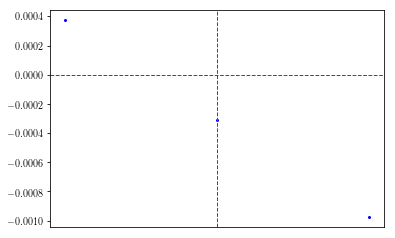

In [71]:
# resta = fstr_M31gd(rstr_M31gd[np.where(rstr_M31gd>0.1)]) - fdrk_M31gd(rstr_M31gd[np.where(rstr_M31gd>0.1)])


# mask, = np.where(abs(resta)<0.0005)


# plt.plot(pointMWgs, rest_MWgs,'.k',markersize=0.5)
plt.plot(pointM31gd[mask1], rest_M31gd[mask1],'o',color='b',markersize=2)
plt.xscale('log')
plt.axhline(0,ls='--', color='r',lw=1)
plt.axvline(req_M31gd,ls='--', color='g',lw=1)

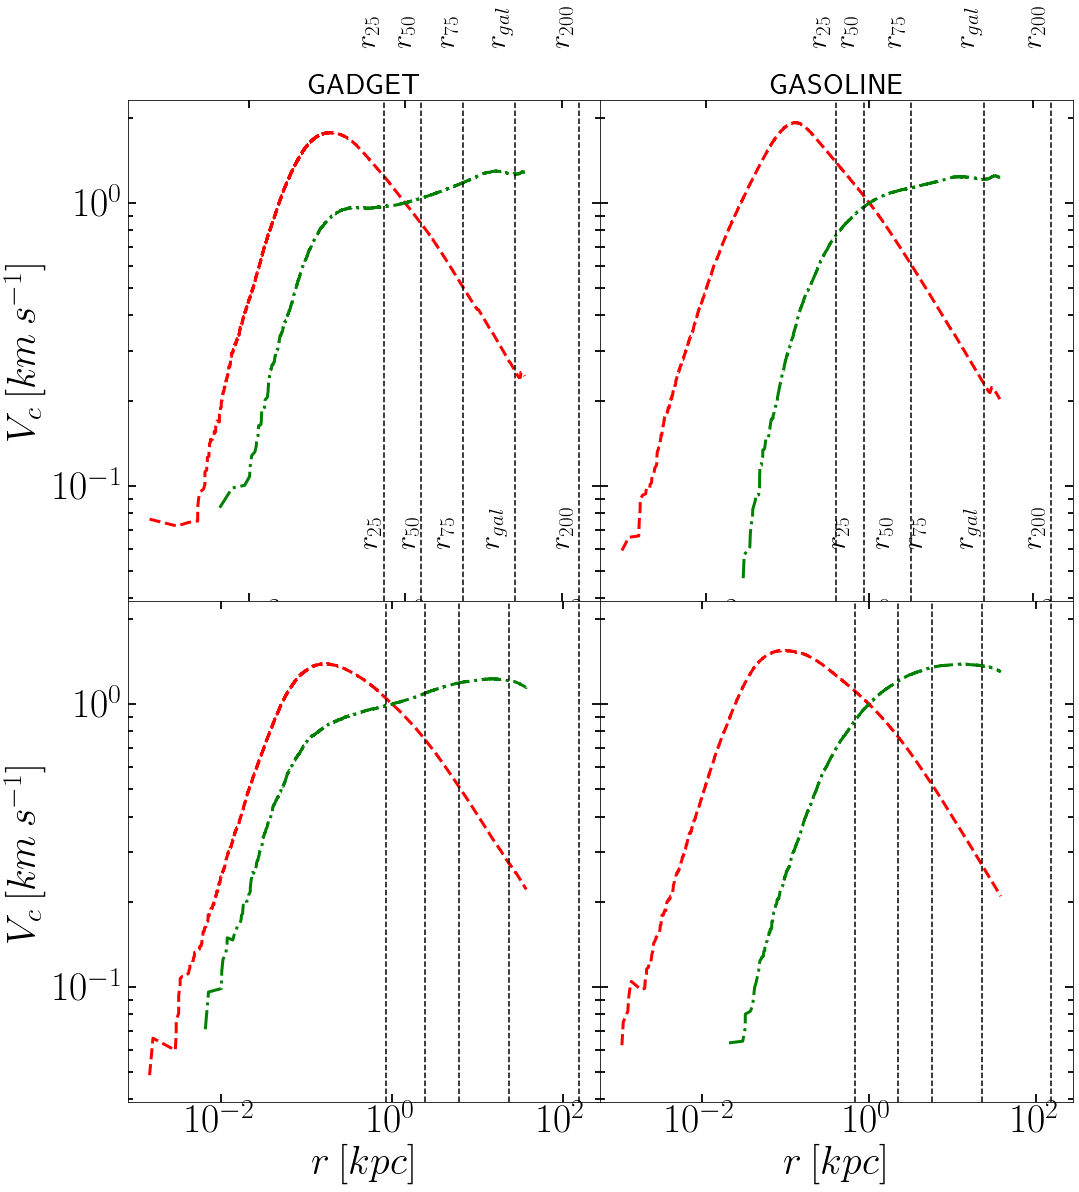

In [115]:
# fig=plt.figure(1,figsize=(16,16))
# fig.subplots_adjust(bottom=0.08, left =0.1, right = 0.95, top = 0.95, wspace=0., hspace= 0)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16), sharey=True)
#                        gridspec_kw = {'height_ratios':[3,1,3,1]})
fig.subplots_adjust(bottom=0.08, left =0.1, right = 0.92, top = 0.95, wspace=0., hspace= 0)

# ax=fig.add_subplot(221)
# ax[0,0].plot(rtot_M31gd[np.where(Vtot_M31gd!=0)],Vtot_M31gd[np.where(Vtot_M31gd!=0)],'-', lw=3, color='k', label= 'Total')
ax[0,0].plot(rstr_M31gd[np.where(Vstr_M31gd!=0)]/req_M31gd,Vstr_M31gd[np.where(Vstr_M31gd!=0)]/fstr_M31gd(req_M31gd),'--',lw=3, color='r', label ='Stars')
# ax[0,0].plot(rgas_M31gd[np.where(Vgas_M31gd!=0)],Vgas_M31gd[np.where(Vgas_M31gd!=0)],':', color ='b',lw=3, label='Gas')
ax[0,0].plot(rdrk_M31gd[np.where(Vdrk_M31gd!=0)]/req_M31gd,Vdrk_M31gd[np.where(Vdrk_M31gd!=0)]/fstr_M31gd(req_M31gd),'-.',color='g', lw=3, label='Dark Matter')

# ax[0,0].text(18, 175, 'A', fontsize=35, color='k', ha='right', va='center')
#plt.legend(handles=[total,stars,gas,drk],fontsize=18, frameon=False)
# ax[0,0].set_xticks([0,5,10,15])
ax[0,0].set_ylabel(r'$V_{c}\:[km\:s^{-1}]$', fontsize=40)
ax[0,0].set_xscale('log')
ax[0,0].set_yscale('log')
# ax[0,0].set_ylim(2,2e2)
# ax[0,0].set_xlim(3e-2,2e2)
# ax[0,0].set_xticks([1e-2,1e-1,1e0,1e1,1e2], minor=True)
# ax[0,0].set_xticklabels([])

ax[0,0].minorticks_on()
ax[0,0].tick_params( labelsize=40)
ax[0,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')

ax[0,0].axvline(r200_M31gd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[0,0].text(r200_M31gd, 3.5, '$r_{200}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[0,0].axvline(r200_M31gd*0.15,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[0,0].text(r200_M31gd*0.15, 3.5, '$r_{gal}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[0,0].axvline(r50_M31gd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[0,0].text(r50_M31gd, 3.5, '$r_{50}$', fontsize=30, color='black', ha='right', va='bottom', rotation=90.)

ax[0,0].axvline(r25_M31gd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[0,0].text(r25_M31gd, 3.5, '$r_{25}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[0,0].axvline(r75_M31gd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[0,0].text(r75_M31gd, 3.5, '$r_{75}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)


# ax[0,0].annotate('', xy=(20,Vtot_M31gd[np.where(Vtot_M31gd!=0)][-1]), xytext=(17, Vtot_M31gd[np.where(Vtot_M31gd!=0)][-1]), 
#                  textcoords='data' ,ha="right", va='center', arrowprops=dict(facecolor='k',ec="none"))

# ax[0,0].text(15, 37, 'Gas', fontsize=30, color='b', ha='center', va='center')
# ax[0,0].text(15, 67, 'Stars', fontsize=30, color='r', ha='center', va='center')
# ax[0,0].text(10, 105, 'Dark Matter', fontsize=30, color='g', ha='center', va='center')
# ax[0,0].text(10, 130, 'Total', fontsize=30, color='k', ha='center', va='center')

ax[0,0].set_title('GADGET', loc='center', fontsize=30)

#------------------------------------------------------

# ax2=fig.add_subplot(222)
# ax[0,1].plot(rtot_M31gs[np.where(Vtot_M31gs!=0)],Vtot_M31gs[np.where(Vtot_M31gs!=0)],'-', lw=3, color='k', label= 'Total')
ax[0,1].plot(rstr_M31gs[np.where(Vstr_M31gs!=0)]/req_M31gs,Vstr_M31gs[np.where(Vstr_M31gs!=0)]/fstr_M31gs(req_M31gs),'--',lw=3, color='r', label ='Stars')
# ax[0,1].plot(rgas_M31gs[np.where(Vgas_M31gs!=0)],Vgas_M31gs[np.where(Vgas_M31gs!=0)],':', color ='b',lw=3, label='Gas')
ax[0,1].plot(rdrk_M31gs[np.where(Vdrk_M31gs!=0)]/req_M31gs,Vdrk_M31gs[np.where(Vdrk_M31gs!=0)]/fstr_M31gs(req_M31gs),'-.',color='g', lw=3, label='Dark Matter')

# ax[0,1].text(18, 175, 'A', fontsize=35, color='k', ha='right', va='center')
#plt.legend(handles=[total,stars,gas,drk],fontsize=18, frameon=False)
ax[0,1].set_xticks([1e-2,1e-1,1e0,1e1,1e2], minor=True)
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')
# ax[0,1].set_ylim(2,2e2)
# ax[0,1].set_xlim(3e-2,2e2)
# ax[0,1].set_xticklabels([])
# ax[0,1].set_yticklabels([])

ax[0,1].tick_params( labelsize=40)
ax[0,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[0,1].annotate('', xy=(20,Vtot_M31gs[np.where(Vtot_M31gs!=0)][-1]), xytext=(17, Vtot_M31gs[np.where(Vtot_M31gs!=0)][-1]), 
#                  textcoords='data', ha="right", va='center', arrowprops=dict(facecolor='k', ec="none"))

ax[0,1].axvline(r200_M31gs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[0,1].text(r200_M31gs, 3.5, '$r_{200}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[0,1].axvline(r200_M31gs*0.15,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[0,1].text(r200_M31gs*0.15, 3.5, '$r_{gal}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[0,1].axvline(r50_M31gs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[0,1].text(r50_M31gs, 3.5, '$r_{50}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[0,1].axvline(r25_M31gs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[0,1].text(r25_M31gs, 3.5, '$r_{25}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[0,1].axvline(r75_M31gs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[0,1].text(r75_M31gs, 3.5, '$r_{75}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[0,1].set_title('GASOLINE', loc='center', fontsize=30)


#---------------------------------------------------------

# ax3=fig.add_subplot(223)
# ax[1,0].plot(rtot_MWgd[np.where(Vtot_MWgd!=0)],Vtot_MWgd[np.where(Vtot_MWgd!=0)],'-', lw=3, color='k', label= 'Total')
ax[1,0].plot(rstr_MWgd[np.where(Vstr_MWgd!=0)]/req_MWgd,Vstr_MWgd[np.where(Vstr_MWgd!=0)]/fstr_MWgd(req_MWgd),'--',lw=3, color='r', label ='Stars')
# ax[1,0].plot(rgas_MWgd[np.where(Vgas_MWgd!=0)],Vgas_MWgd[np.where(Vgas_MWgd!=0)],':', color ='b',lw=3, label='Gas')
ax[1,0].plot(rdrk_MWgd[np.where(Vdrk_MWgd!=0)]/req_MWgd,Vdrk_MWgd[np.where(Vdrk_MWgd!=0)]/fstr_MWgd(req_MWgd),'-.',color='g', lw=3, label='Dark Matter')

# ax[1,0].text(18, 175, 'B', fontsize=35, color='k', ha='right', va='center')
#plt.legend(handles=[total,stars,gas,drk],fontsize=18, frameon=False)
ax[1,0].set_xlabel(r'$r\:[kpc]$', fontsize=40)
ax[1,0].set_ylabel(r'$V_{c}\:[km\:s^{-1}]$', fontsize=40)
# ax[1,0].set_xticks([1e-2,1e-1,1e0,1e1,1e2], minor=True)
ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')
# ax[1,0].set_ylim(2,2e2)
# ax[1,0].set_xlim(3e-2,2e2)
ax[1,0].minorticks_on()
ax[1,0].tick_params( labelsize=40)
ax[1,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[1,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[1,0].annotate('', xy=(rgal,0), xytext=(rgal, 27), textcoords='data', 
#              fontsize=18,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.01),ha="center")
# ax[1,0].text(rgal, 32, '$r_{gal} =$'+ str('%.2f'%rgal), fontsize=20, color='black', 
#          ha='center', va='center')
# ax[1,0].annotate('', xy=(20,Vtot_MWgd[np.where(Vtot_MWgd!=0)][-1]), xytext=(17, Vtot_MWgd[np.where(Vtot_MWgd!=0)][-1]), 
#                  textcoords='data', ha="right", va='center',arrowprops=dict(facecolor='k', ec="none"))

ax[1,0].axvline(r200_MWgd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[1,0].text(r200_MWgd, 3.5, '$r_{200}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[1,0].axvline(r200_MWgd*0.15,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[1,0].text(r200_MWgd*0.15, 3.5, '$r_{gal}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[1,0].axvline(r50_MWgd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[1,0].text(r50_MWgd, 3.5, '$r_{50}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[1,0].axvline(r25_MWgd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[1,0].text(r25_MWgd, 3.5, '$r_{25}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[1,0].axvline(r75_MWgd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[1,0].text(r75_MWgd, 3.5, '$r_{75}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

#---------------------------------------------------------------------------------------
# ax4=fig.add_subplot(224)
# ax[1,1].plot(rtot_MWgs[np.where(Vtot_MWgs!=0)],Vtot_MWgs[np.where(Vtot_MWgs!=0)],'-', lw=3, color='k', label= 'Total')
ax[1,1].plot(rstr_MWgs[np.where(Vstr_MWgs!=0)]/req_MWgs,Vstr_MWgs[np.where(Vstr_MWgs!=0)]/fstr_MWgs(req_MWgs),'--',lw=3, color='r', label ='Stars')
# ax[1,1].plot(rgas_MWgs[np.where(Vgas_MWgs!=0)],Vgas_MWgs[np.where(Vgas_MWgs!=0)],':', color ='b',lw=3, label='Gas')
ax[1,1].plot(rdrk_MWgs[np.where(Vdrk_MWgs!=0)]/req_MWgs,Vdrk_MWgs[np.where(Vdrk_MWgs!=0)]/fstr_MWgs(req_MWgs),'-.',color='g', lw=3, label='Dark Matter')

# ax[1,1].text(18, 175, 'B', fontsize=35, color='k', ha='right', va='center')
#plt.legend(handles=[total,stars,gas,drk],fontsize=18, frameon=False)
ax[1,1].set_xlabel(r'$r\:[kpc]$',fontsize=40)
# ax[1,1].set_xticks([1e-2,1e-1,1e0,1e1,1e2], minor=True)
# ax[1,1].set_yticklabels([])
ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
# ax[1,1].set_ylim(2,2e2)
# ax[1,1].set_xlim(3e-2,2e2)
ax[1,1].minorticks_on()
ax[1,1].tick_params( labelsize=40)
ax[1,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[1,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[1,1].annotate('', xy=(20,Vtot_MWgs[np.where(Vtot_MWgs!=0)][-1]), xytext=(17, Vtot_MWgs[np.where(Vtot_MWgs!=0)][-1]), 
#                  textcoords='data', ha="right", va='center',arrowprops=dict(facecolor='k', ec="none"))

ax[1,1].axvline(r200_MWgs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[1,1].text(r200_MWgs, 3.5, '$r_{200}$', fontsize=30, color='black',ha='right', va='bottom',rotation=90.)

ax[1,1].axvline(r200_MWgs*0.15,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[1,1].text(r200_MWgs*0.15, 3.5, '$r_{gal}$', fontsize=30, color='black',  ha='right', va='bottom',rotation=90.)

ax[1,1].axvline(r50_MWgs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[1,1].text(r50_MWgs, 3.5, '$r_{50}$', fontsize=30, color='black',  ha='right', va='bottom',rotation=90.)

ax[1,1].axvline(r25_MWgs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[1,1].text(r25_MWgs, 3.5, '$r_{25}$', fontsize=30, color='black',  ha='right', va='bottom',rotation=90.)

ax[1,1].axvline(r75_MWgs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[1,1].text(r75_MWgs, 3.5, '$r_{75}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)



In [62]:
mean(rstr_M31gd[np.where(rstr_M31gd>0.1)][mask])

4.9298789999999997

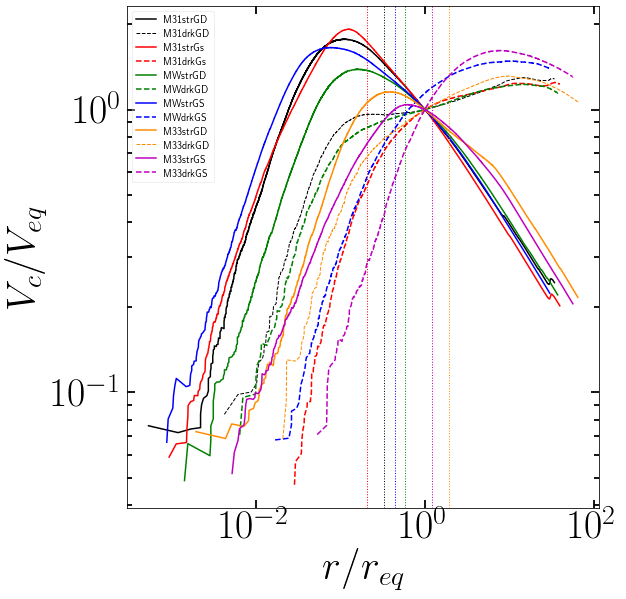

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
#                        gridspec_kw = {'height_ratios':[3,1,3,1]})
fig.subplots_adjust(bottom=0.08, left =0.1, right = 0.92, top = 0.95, wspace=0., hspace= 0)

# ax=fig.add_subplot(221)
ax.plot(rstr_M31gd[np.where(Vstr_M31gd!=0)]/req_M31gd,Vstr_M31gd[np.where(Vstr_M31gd!=0)]/fstr_M31gd(req_M31gd),'-',lw=1.5, color='k', label ='M31strGD')
ax.plot(rdrk_M31gd[np.where(Vdrk_M31gd!=0)]/req_M31gd,Vdrk_M31gd[np.where(Vdrk_M31gd!=0)]/fstr_M31gd(req_M31gd),'--',color='k', lw=1, label='M31drkGD')
ax.axvline(r50_M31gd/req_M31gd,ymin=0,ymax=200, ls=':', color='k',lw=1)

ax.plot(rstr_M31gs[np.where(Vstr_M31gs!=0)]/req_M31gs,Vstr_M31gs[np.where(Vstr_M31gs!=0)]/fstr_M31gs(req_M31gs),'-',lw=1.5, color='r', label ='M31strGs')
ax.plot(rdrk_M31gs[np.where(Vdrk_M31gs!=0)]/req_M31gs,Vdrk_M31gs[np.where(Vdrk_M31gs!=0)]/fstr_M31gs(req_M31gs),'--',color='r', lw=1.5, label='M31drkGs')
ax.axvline(r50_M31gs/req_M31gs,ymin=0,ymax=200, ls=':', color='r',lw=1)

ax.plot(rstr_MWgd[np.where(Vstr_MWgd!=0)]/req_MWgd,Vstr_MWgd[np.where(Vstr_MWgd!=0)]/fstr_MWgd(req_MWgd),'-',lw=1.5, color='g', label ='MWstrGD')
ax.plot(rdrk_MWgd[np.where(Vdrk_MWgd!=0)]/req_MWgd,Vdrk_MWgd[np.where(Vdrk_MWgd!=0)]/fstr_MWgd(req_MWgd),'--',color='g', lw=1.5, label='MWdrkGD')
ax.axvline(r50_MWgd/req_MWgd,ymin=0,ymax=200, ls=':', color='g',lw=1)

ax.plot(rstr_MWgs[np.where(Vstr_MWgs!=0)]/req_MWgs,Vstr_MWgs[np.where(Vstr_MWgs!=0)]/fstr_MWgs(req_MWgs),'-',lw=1.5, color='b', label ='MWstrGS')
ax.plot(rdrk_MWgs[np.where(Vdrk_MWgs!=0)]/req_MWgs,Vdrk_MWgs[np.where(Vdrk_MWgs!=0)]/fstr_MWgs(req_MWgs),'--',color='b', lw=1.5, label='MWdrkGS')
ax.axvline(r50_MWgs/req_MWgs,ymin=0,ymax=200, ls=':', color='b',lw=1)

ax.plot(rstr_M33gd[np.where(Vstr_M33gd!=0)]/req_M33gd,Vstr_M33gd[np.where(Vstr_M33gd!=0)]/fstr_M33gd(req_M33gd),'-',lw=1.5, color='darkorange', label ='M33strGD')
ax.plot(rdrk_M33gd[np.where(Vdrk_M33gd!=0)]/req_M33gd,Vdrk_M33gd[np.where(Vdrk_M33gd!=0)]/fstr_M33gd(req_M33gd),'--',color='darkorange', lw=1, label='M33drkGD')
ax.axvline(r50_M33gd/req_M33gd,ymin=0,ymax=200, ls=':', color='darkorange',lw=1)

ax.plot(rstr_M33gs[np.where(Vstr_M33gs!=0)]/req_M33gs,Vstr_M33gs[np.where(Vstr_M33gs!=0)]/fstr_M33gs(req_M33gs),'-',lw=1.5, color='m', label ='M33strGS')
ax.plot(rdrk_M33gs[np.where(Vdrk_M33gs!=0)]/req_M33gs,Vdrk_M33gs[np.where(Vdrk_M33gs!=0)]/fstr_M33gs(req_M33gs),'--',color='m', lw=1.5, label='M33drkGS')
ax.axvline(r50_M33gs/req_M33gs,ymin=0,ymax=200, ls=':', color='m',lw=1)

ax.set_xscale('log')
ax.set_yscale('log')

# ax.text(18, 175, 'A', fontsize=35, color='k', ha='right', va='center')
#plt.legend(handles=[total,stars,gas,drk],fontsize=18, frameon=False)
# ax[0,0].set_xticklabels([])
# ax[0,0].set_xticks([0,5,10,15])
ax.set_ylabel(r'$V_{c}/V_{eq}$', fontsize=40)
ax.set_xlabel(r'$r/r_{eq}$', fontsize=40)
# ax.set_ylim(0,190)
# ax.set_xlim(0,200)
ax.minorticks_on()
ax.tick_params( labelsize=40)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
plt.legend(framealpha=0.3)

plt.show()

/home/omarioni/.conda/envs/conda-env/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in divide
  from ipykernel import kernelapp as app
/home/omarioni/.conda/envs/conda-env/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app


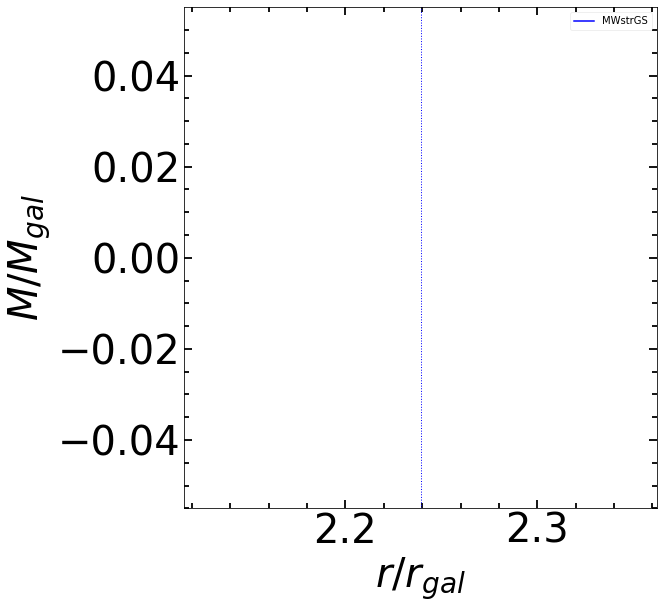

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
#                        gridspec_kw = {'height_ratios':[3,1,3,1]})
fig.subplots_adjust(bottom=0.08, left =0.1, right = 0.92, top = 0.95, wspace=0., hspace= 0)

# ax=fig.add_subplot(221)
# ax.plot(rstr_M31gd/(r200_M31gd*0.15),Mcstr_M31gd/Mgal_M31gd,'-',lw=1.5, color='k', label ='M31strGD')
# ax.axvline(r50_M31gd/(r200_M31gd*0.15),ymin=0,ymax=2, ls=':', color='k',lw=1)

# ax.plot(rstr_M31gs/(r200_M31gs*0.15),Mcstr_M31gs/Mgal_M31gs,'-',lw=1.5, color='r', label ='M31strGs')
# ax.axvline(r50_M31gs,ymin=0,ymax=200, ls=':', color='r',lw=1)

# ax.plot(rstr_MWgd/(r200_MWgd*0.15),Mcstr_MWgd/Mgal_MWgd,'-',lw=1.5, color='g', label ='MWstrGD')
# ax.axvline(r50_MWgd,ymin=0,ymax=200, ls=':', color='g',lw=1)

ax.plot(rstr_MWgs/(r200_MWgs*0.15),Mcstr_MWgs/Mgal_MWgs,'-',lw=1.5, color='b', label ='MWstrGS')
ax.axvline(r50_MWgs,ymin=0,ymax=200, ls=':', color='b',lw=1)

# ax.plot(rstr_M33gd/(r200_M33gd*0.15),Mcstr_M33gd/Mgal_M33gd,'-',lw=1.5, color='darkorange', label ='M33strGD')
# ax.axvline(r50_M33gd,ymin=0,ymax=200, ls=':', color='darkorange',lw=1)

# ax.plot(rstr_M33gs/(r200_M33gs*0.15),Mcstr_M33gs/Mgal_M33gs,'-',lw=1.5, color='m', label ='M33strGS')
# ax.axvline(r50_M33gs,ymin=0,ymax=200, ls=':', color='m',lw=1)

# ax.set_xscale('log')
# ax.set_yscale('log')

# ax.text(18, 175, 'A', fontsize=35, color='k', ha='right', va='center')
#plt.legend(handles=[total,stars,gas,drk],fontsize=18, frameon=False)
# ax[0,0].set_xticklabels([])
# ax[0,0].set_xticks([0,5,10,15])
ax.set_ylabel(r'$M/M_{gal}$', fontsize=40)
ax.set_xlabel(r'$r/r_{gal}$', fontsize=40)
# ax.set_ylim(0,190)
# ax.set_xlim(0,200)
ax.minorticks_on()
ax.tick_params( labelsize=40)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
plt.legend(framealpha=0.3)

plt.show()

In [20]:
#path = 'home/ornela/PYTHON/'
path = '/home/omarioni/'

M31_gd  = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_Mcum.dat')

Mgal_M31gd  = M31_gd[:,9]

print Mgal_M31gd

[  3.02298827e-06   6.04597653e-06   9.06896457e-06 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


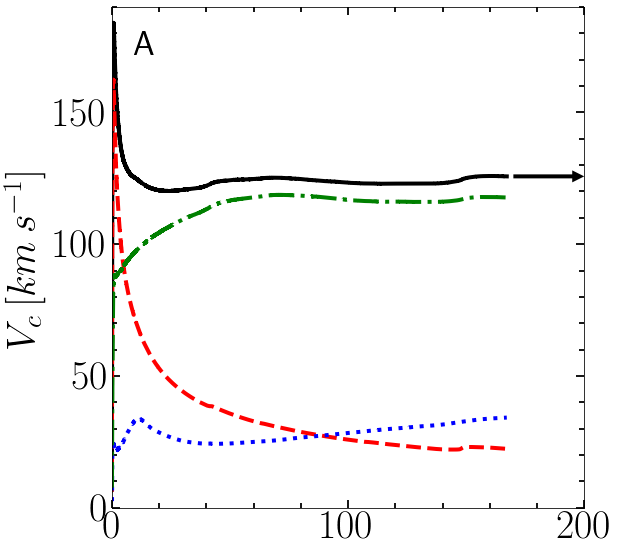

In [13]:
# fig=plt.figure(1,figsize=(16,16))
# fig.subplots_adjust(bottom=0.08, left =0.1, right = 0.95, top = 0.95, wspace=0., hspace= 0)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
#                        gridspec_kw = {'height_ratios':[3,1,3,1]})
fig.subplots_adjust(bottom=0.08, left =0.1, right = 0.92, top = 0.95, wspace=0., hspace= 0)

# ax=fig.add_subplot(221)
ax.plot(rtot_M31gd[np.where(Vtot_M31gd!=0)],Vtot_M31gd[np.where(Vtot_M31gd!=0)],'-', lw=4, color='k', label= 'Total')
ax.plot(rstr_M31gd[np.where(Vstr_M31gd!=0)],Vstr_M31gd[np.where(Vstr_M31gd!=0)],'--',lw=4, color='r', label ='Stars')
ax.plot(rgas_M31gd[np.where(Vgas_M31gd!=0)],Vgas_M31gd[np.where(Vgas_M31gd!=0)],':', color ='b',lw=4, label='Gas')
ax.plot(rdrk_M31gd[np.where(Vdrk_M31gd!=0)],Vdrk_M31gd[np.where(Vdrk_M31gd!=0)],'-.',color='g', lw=4, label='Dark Matter')

ax.text(18, 175, 'A', fontsize=35, color='k', ha='right', va='center')
#plt.legend(handles=[total,stars,gas,drk],fontsize=18, frameon=False)
# ax[0,0].set_xticklabels([])
# ax[0,0].set_xticks([0,5,10,15])
ax.set_ylabel(r'$V_{c}\:[km\:s^{-1}]$', fontsize=40)
ax.set_ylim(0,190)
ax.set_xlim(0,200)
ax.minorticks_on()
ax.tick_params( labelsize=40)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
ax.annotate('', xy=(200,Vtot_M31gd[np.where(Vtot_M31gd!=0)][-1]), xytext=(170, Vtot_M31gd[np.where(Vtot_M31gd!=0)][-1]), textcoords='data' ,ha="right", va='center',
             arrowprops=dict(facecolor='k',ec="none"))
# ax[0,0].text(17, Vtot_M31gd[np.where(Vtot_M31gd!=0)][-1], r'$V_{vir}$', fontsize=30, color='deeppink', ha='right', va='center')
# ax[0,0].text(15, 37, 'Gas', fontsize=30, color='b', ha='center', va='center')
# ax[0,0].text(15, 67, 'Stars', fontsize=30, color='r', ha='center', va='center')
# ax[0,0].text(10, 105, 'Dark Matter', fontsize=30, color='g', ha='center', va='center')
# ax[0,0].text(10, 130, 'Total', fontsize=30, color='k', ha='center', va='center')
# ax[0,0].set_title('GADGET', loc='center', fontsize=30)
plt.show()